In [17]:
import os

import numpy as np
from pyddeeg.signal_processing.rqa_toolbox.utils import extract_signal_windows
from pyddeeg.signal_processing.rqa_toolbox.rqa import compute_rqa_metrics_for_window

import matplotlib.pyplot as plt

PATIENT: int = 0
CHANNEL: int = 11 # T7
BAND: int = 4 # Gamma

PATH: str = os.path.join("/home/mario/Python/Datasets/EEG/timeseries/processed/zerolag", "DD_UP_preprocess_20.npz")

In [11]:
def compute_rqa_metrics_for_signal(
    signal: np.ndarray,
    window_size: int,
    stride: int,
    embedding_dim: int = 10,
    time_delay: int = 1,
    radius: float = 0.8,
    distance_metric: str = "euclidean",
    metrics_to_use: list = None
) -> np.ndarray:
    """
    Compute RQA metrics for a signal using sliding windows and return as a tensor.
    
    Parameters:
    -----------
    signal : np.ndarray
        1D array containing the signal to analyze
    window_size : int
        Size of each window in samples
    stride : int
        Step size between consecutive windows in samples
    embedding_dim : int
        Embedding dimension for phase space reconstruction
    time_delay : int
        Time delay for phase space reconstruction
    radius : float
        Threshold radius for recurrence detection
    distance_metric : str
        Distance metric to use for recurrence calculation
        
    Returns:
    --------
    metrics_tensor : np.ndarray
        Tensor with shape [metrics, window_points] containing RQA metrics for each window
    """
    # Extract windows from signal
    windows = extract_signal_windows(signal, window_size, stride)
    
    # Initialize list to store metrics for each window
    all_metrics = []
    
    # Process each window
    for window_signal in windows:
        metrics, _ = compute_rqa_metrics_for_window(
            window_signal=window_signal,
            embedding_dim=embedding_dim,
            time_delay=time_delay,
            radius=radius,
            distance_metric=distance_metric,
            metrics_to_use=metrics_to_use
        )
        all_metrics.append(list(metrics.values()))
    
    # Convert to numpy array and transpose to get [metrics, window_points] shape
    metrics_tensor = np.array(all_metrics).T
    
    # Extract metric names for reference
    metric_names = list(metrics.keys())
    
    return metrics_tensor, metric_names

In [21]:
import pandas as pd
from typing import Dict, List, Tuple, Optional, Union

def compute_multi_window_rqa(
    signal: np.ndarray,
    window_sizes: List[int],
    embedding_dim: int = 10,
    time_delay: int = 1,
    radius: float = 0.8,
    distance_metric: str = "euclidean",
    metrics_to_use: Optional[List[str]] = None,
    verbose: bool = False
) -> Dict:
    """
    Compute RQA metrics for multiple window sizes.
    
    Parameters:
    -----------
    signal : np.ndarray
        1D array containing the signal to analyze
    window_sizes : List[int]
        List of window sizes to analyze
    embedding_dim : int
        Embedding dimension for phase space reconstruction
    time_delay : int
        Time delay for phase space reconstruction
    radius : float
        Threshold radius for recurrence detection
    distance_metric : str
        Distance metric to use for recurrence calculation
    metrics_to_use : Optional[List[str]]
        List of specific RQA metrics to compute (None = all metrics)
    verbose : bool
        Whether to print detailed statistics for each window size
    
    Returns:
    --------
    results : Dict
        Dictionary containing metrics tensors and metadata for each window size
    """
    # Dictionary to store results for each window size
    results = {
        'window_sizes': window_sizes,
        'metrics_data': {},
        'signal': signal,
        'signal_length': len(signal),
    }
    
    # Statistics for DataFrame if verbose is True
    stats_data = []
    
    # Process each window size
    for window_size in window_sizes:
        # Use 50% stride
        stride = window_size // 2
        
        # Compute RQA metrics
        metrics_tensor, metric_names = compute_rqa_metrics_for_signal(
            signal=signal,
            window_size=window_size,
            stride=stride,
            embedding_dim=embedding_dim,
            time_delay=time_delay,
            radius=radius,
            distance_metric=distance_metric,
            metrics_to_use=metrics_to_use
        )
        
        # Store results for this window size
        results['metrics_data'][window_size] = {
            'tensor': metrics_tensor,
            'metric_names': metric_names,
            'stride': stride,
            'window_centers': np.array([stride * i + window_size // 2 for i in range(metrics_tensor.shape[1])])
        }
        
        # Collect statistics for DataFrame if verbose is True
        if verbose:
            for i, metric_name in enumerate(metric_names):
                metric_values = metrics_tensor[i]
                stats_data.append({
                    'Window Size': window_size,
                    'Stride': stride,
                    'Metric': metric_name,
                    'Points': len(metric_values),
                    'Mean': np.mean(metric_values),
                    'Std': np.std(metric_values),
                    'Min': np.min(metric_values),
                    'Max': np.max(metric_values),
                    'Median': np.median(metric_values),
                    '25%': np.percentile(metric_values, 25),
                    '75%': np.percentile(metric_values, 75)
                })
    
    # Store first set of metric names (should be the same for all windows)
    results['metric_names'] = results['metrics_data'][window_sizes[0]]['metric_names']
    
    # Print statistics if verbose
    if verbose:
        stats_df = pd.DataFrame(stats_data)
        print("\n===== RQA Metrics Statistics =====\n")
        print(stats_df)
        
        # Also create a more concise summary grouped by window size and metric
        summary = stats_df.groupby(['Window Size', 'Metric']).agg({
            'Mean': 'mean', 'Std': 'mean', 'Min': 'min', 'Max': 'max'
        }).reset_index()
        print("\n===== Summary by Window Size and Metric =====\n")
        print(summary)
        
        # Store the DataFrame in results
        results['stats_df'] = stats_df
        results['summary_df'] = summary
    
    return results

def visualize_multi_window_rqa(
    results: Dict,
    metric_index: int = 0,
    figsize: Tuple[int, int] = (12, 8),
    show_legend: bool = True,
    grid: bool = True,
    title_suffix: str = "",
    marker_size: int = 4,
    line_alpha: float = 0.8
):
    """
    Visualize RQA metrics for multiple window sizes with the original signal.
    
    Parameters:
    -----------
    results : Dict
        Dictionary output from compute_multi_window_rqa
    metric_index : int
        Index of the RQA metric to visualize
    figsize : tuple
        Figure size for visualization
    show_legend : bool
        Whether to show the legend
    grid : bool
        Whether to show grid on the plot
    title_suffix : str
        Optional text to add to the plot title
    marker_size : int
        Size of markers in the plot
    line_alpha : float
        Transparency of plotted lines
        
    Returns:
    --------
    fig, axes : Tuple
        Figure and axes objects for further customization
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot original signal in bottom subplot
    signal = results['signal']
    time_points = np.arange(len(signal))
    ax2.plot(time_points, signal, 'k-', alpha=0.7, linewidth=1)
    ax2.set_xlabel('Time (samples)')
    ax2.set_ylabel('Signal Amplitude')
    ax2.set_title('Original Signal')
    
    # Extract window sizes and metric names
    window_sizes = results['window_sizes']
    metric_names = results['metric_names']
    selected_metric = metric_names[metric_index]
    
    # Generate colors for different window sizes
    colors = plt.cm.viridis(np.linspace(0, 1, len(window_sizes)))
    
    # Plot metrics for each window size
    for i, window_size in enumerate(window_sizes):
        window_data = results['metrics_data'][window_size]
        metrics_tensor = window_data['tensor']
        window_centers = window_data['window_centers']
        stride = window_data['stride']
        
        # Plot selected metric
        metric_values = metrics_tensor[metric_index]
        ax1.plot(window_centers, metric_values, '-o', color=colors[i], 
                 alpha=line_alpha, markersize=marker_size, 
                 label=f'Window: {window_size}, Stride: {stride}')
    
    # Set up legend and labels for upper subplot
    if show_legend:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                   ncol=len(window_sizes)//2 + 1)
    
    ax1.set_ylabel(f'RQA Metric: {selected_metric}')
    title = f'RQA {selected_metric} for Different Window Sizes'
    if title_suffix:
        title += f' {title_suffix}'
    ax1.set_title(title)
    
    if grid:
        ax1.grid(True, alpha=0.3)
    
    # Adjust layout for legend placement
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    
    return fig, (ax1, ax2)

Signal shape: (68000,)
Metrics tensor shape: (1, 1359)
Metrics: ['RR']


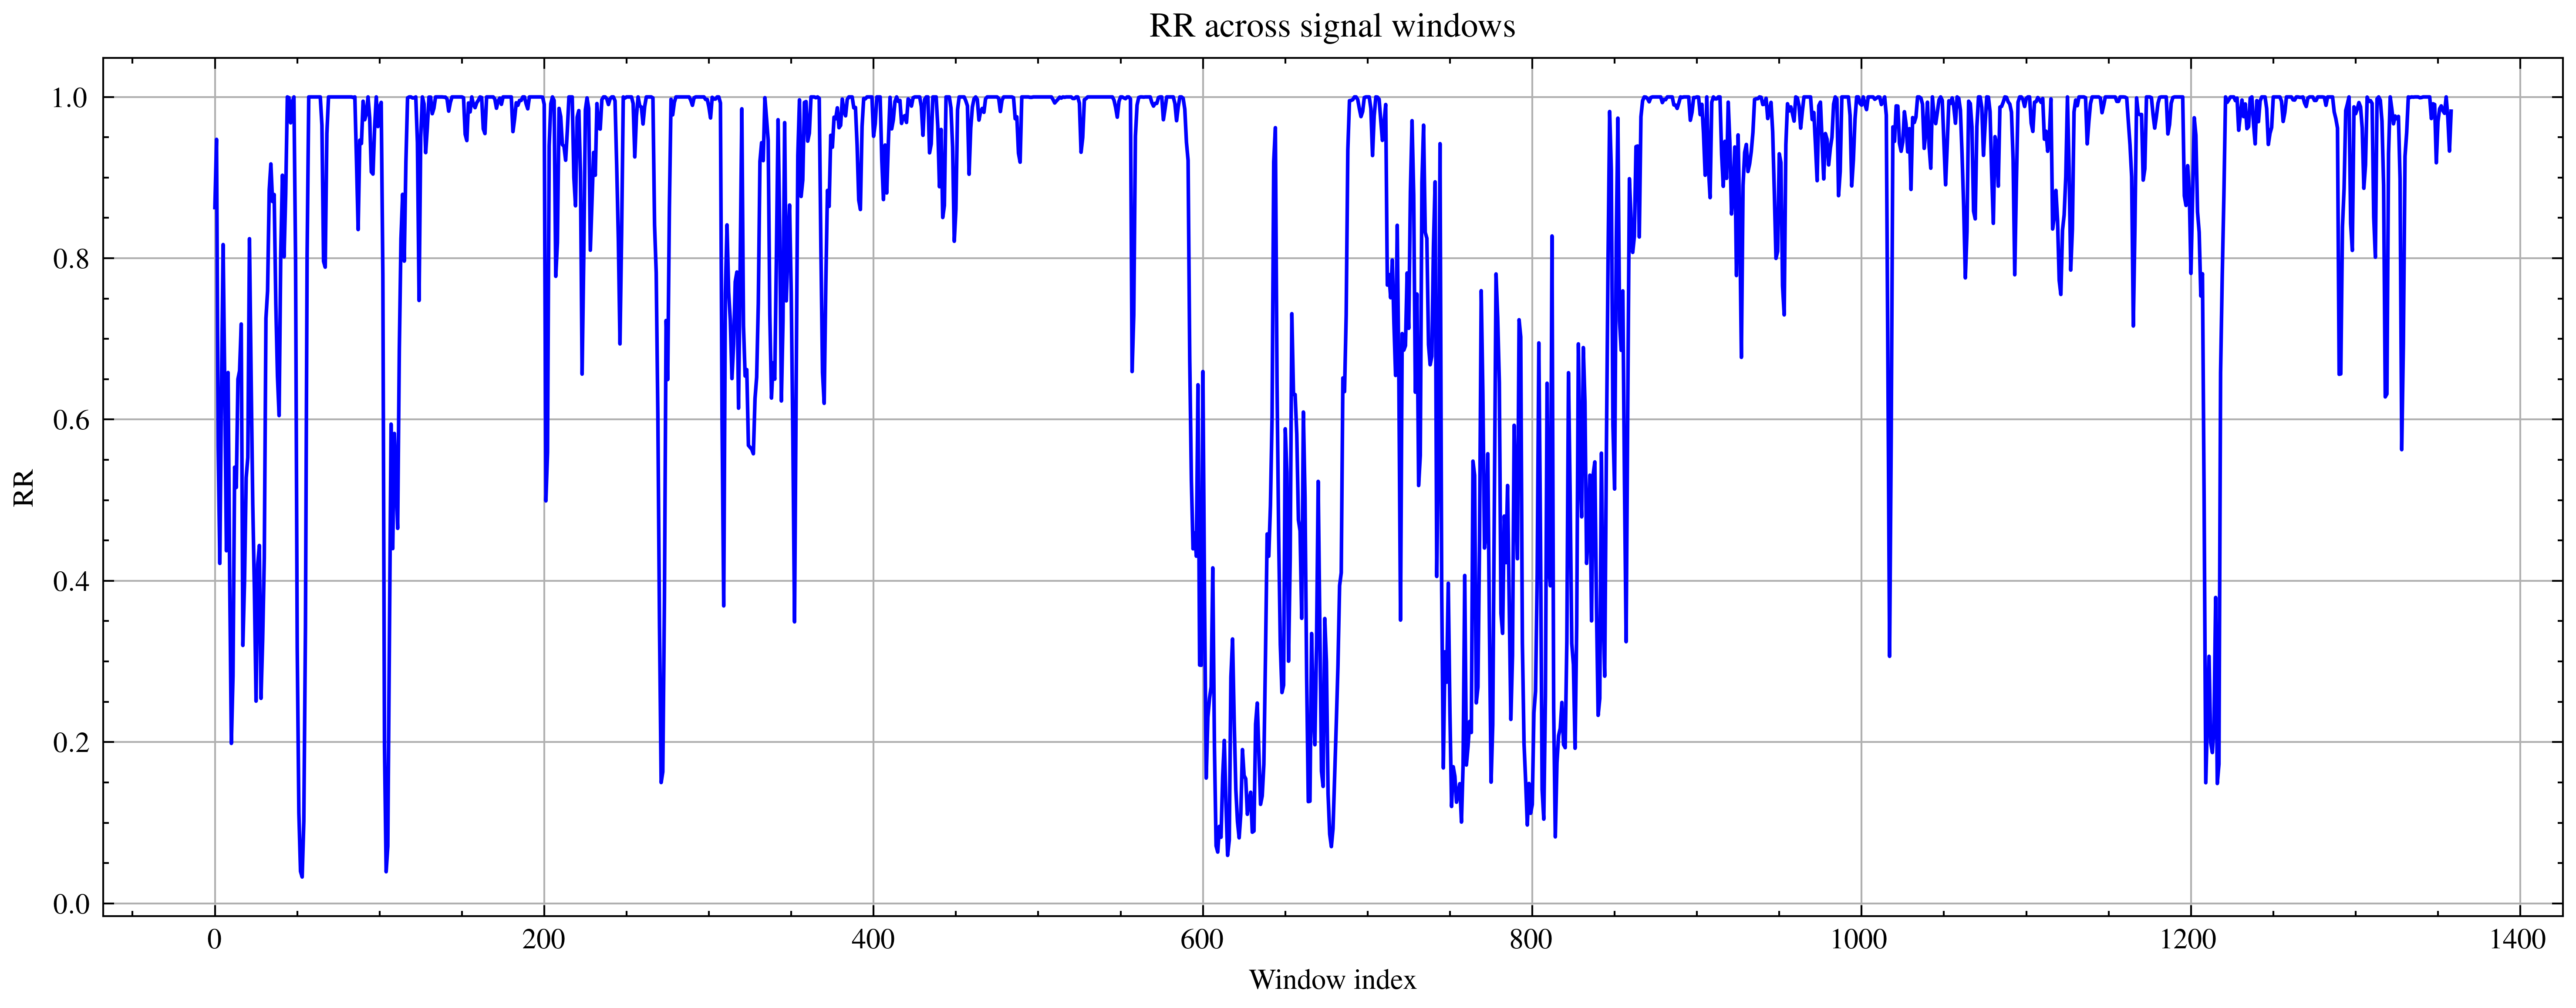

In [18]:
# Example usage

signal = np.load(PATH)["data"]
signal = signal[PATIENT, CHANNEL, :, BAND]
print(f"Signal shape: {signal.shape}")

# Process signal and get metrics tensor
metrics_tensor, metric_names = compute_rqa_metrics_for_signal(
    signal=signal, 
    window_size=100, 
    stride=50,
    embedding_dim=10,
    time_delay=1,
    radius=0.8,
    metrics_to_use=["RR"]
)

print(f"Metrics tensor shape: {metrics_tensor.shape}")
print(f"Metrics: {metric_names}")

plt.figure(figsize=(10, 4))
plt.plot(metrics_tensor[0], 'b-')
plt.title(f'{metric_names[0]} across signal windows')
plt.xlabel('Window index')
plt.ylabel(metric_names[0])
plt.grid(True)
plt.tight_layout()


===== RQA Metrics Statistics =====

    Window Size  Stride Metric  Points      Mean       Std       Min  Max  \
0            50      25     RR    2719  0.832581  0.266985  0.025580  1.0   
1            50      25    DET    2719  0.992562  0.023600  0.000000  1.0   
2            50      25    LAM    2719  0.981687  0.071095  0.070175  1.0   
3           100      50     RR    1359  0.830589  0.263335  0.032726  1.0   
4           100      50    DET    1359  0.995426  0.008859  0.931193  1.0   
5           100      50    LAM    1359  0.985657  0.051623  0.473324  1.0   
6           200     100     RR     679  0.828635  0.259294  0.056221  1.0   
7           200     100    DET     679  0.996394  0.006878  0.955914  1.0   
8           200     100    LAM     679  0.988729  0.038045  0.576339  1.0   
9           400     200     RR     339  0.826142  0.253504  0.102269  1.0   
10          400     200    DET     339  0.996889  0.005741  0.969824  1.0   
11          400     200    LAM     339 

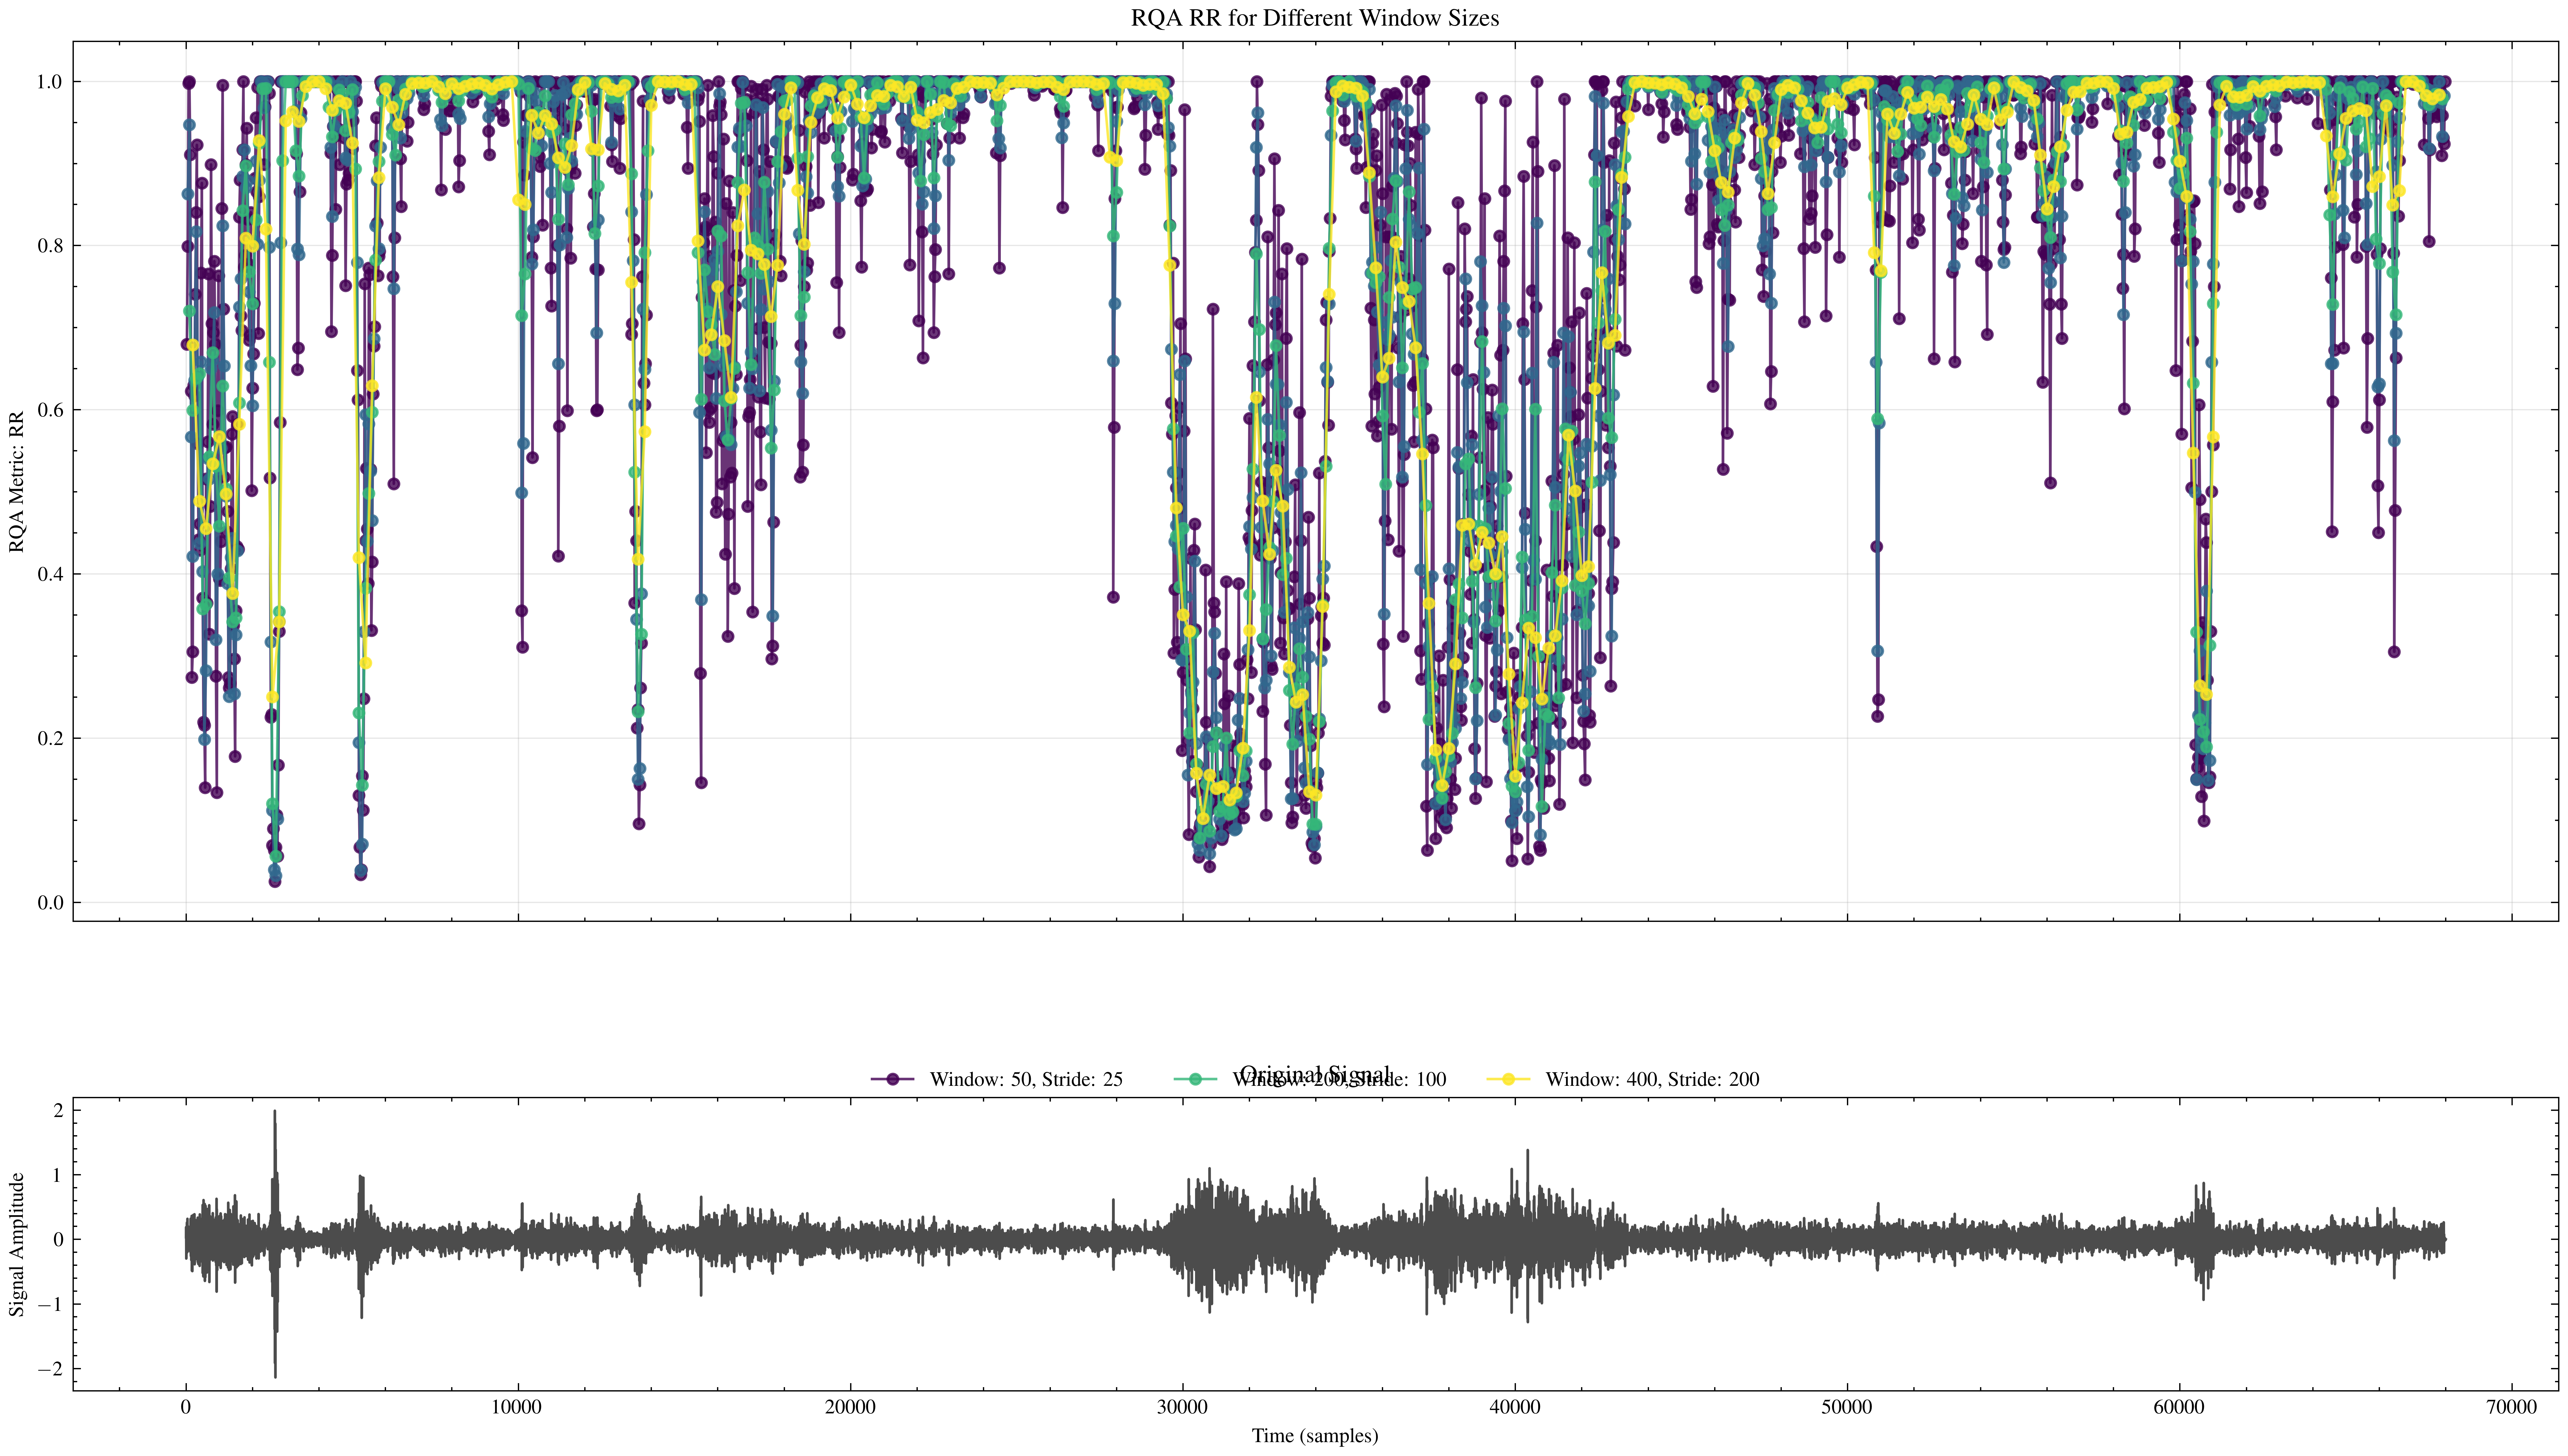

In [22]:
# Load signal
signal = np.load(PATH)["data"]
signal = signal[PATIENT, CHANNEL, :, BAND]

# Define window sizes to analyze
window_sizes = [50, 100, 200, 400]

# Compute RQA metrics for multiple window sizes
rqa_results = compute_multi_window_rqa(
    signal=signal,
    window_sizes=window_sizes,
    embedding_dim=10,
    time_delay=1,
    radius=0.8,
    metrics_to_use=["RR", "DET", "LAM"],
    verbose=True  # Set to True to see the statistics DataFrame
)

# Visualize the results for a specific metric (0=RR, 1=DET, 2=LAM)
fig, axes = visualize_multi_window_rqa(
    results=rqa_results,
    metric_index=0,  # Show the first metric (RR)
    figsize=(14, 8)
)

plt.show()